In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import random 
import numpy as np
import math
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
str_to_inx = {str:inx for inx, str in enumerate(chars, start=1)}
str_to_inx['.'] = 0
inx_to_str = {str:inx for inx, str in str_to_inx.items()}
vocab_size = len(inx_to_str)
inx_to_str

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [4]:
# build the dataset
random.shuffle(words)
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for word in words:
    word = block_size * '.' + word + '.'
    end_inx = block_size
    for start_inx, char in enumerate(word[block_size:]):
        X.append([str_to_inx[ch] for ch in word[start_inx:end_inx]])
        Y.append(str_to_inx[char])
        end_inx += 1


X, Y = torch.tensor(X), torch.tensor(Y)
X

tensor([[ 0,  0,  0],
        [ 0,  0, 13],
        [ 0, 13,  1],
        ...,
        [ 5, 19, 16],
        [19, 16, 25],
        [16, 25, 14]])

In [5]:
# data set splits
train_range = math.ceil(len(X) * 0.8)
dev_range = (len(X) - train_range) // 2

training_set = X[:train_range]
dev_set = X[train_range:train_range+dev_range]
test_set = X[train_range+dev_range:]

y_training_set = Y[:train_range]
y_dev_set = Y[train_range:train_range+dev_range]
y_test_set = Y[train_range+dev_range:]

assert training_set.nelement() + dev_set.nelement() + test_set.nelement() == X.nelement(), "Bad split"

Why *0.01, etc.? Weights are deviating from 0 too much (i.e they're very wrong) at the initialization and it unnecessarily increases the loss at the beginning of the training. When they are too diverse tanh produces values very close to -1 or 1 which is bad for the gradient flow (see micrograd tanh implementation; gradient doesn't flow because it's in the flattened region). Init weight should be very close to 0 but not 0

In [6]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((block_size*n_embd, n_hidden), generator=g) * (5/3)*(block_size*n_embd)**0.5 #Kaiming init
#b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 
b2 = torch.randn(vocab_size, generator=g) * 0

# BatchNorm parameters
batch_norm_gain = torch.ones((1, n_hidden))  # shift
batch_norm_bias = torch.zeros((1, n_hidden)) # property
batch_mean_running = torch.zeros((1, n_hidden))
batch_std_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, batch_norm_gain, batch_norm_bias]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters) # number of parameters in total

12097

In [18]:
# train
inxs = []
losses = []
batch_size = 64
steps = 100000
for i in range(steps):
    # minibatch construct
    inx = torch.randint(0, training_set.shape[0], (batch_size,), generator=g)

    # forward pass
    emb = C[training_set[inx]] # grab only those rows from the minibatch 
    emb_conc = emb.view(-1, block_size*n_embd)

    # linear layer
    h_preact = emb_conc @ W1 #+ b1 adding b1 is wasteful - see mu and std

    # BatchNorm Layer
    batch_mean_i = h_preact.mean(dim=0, keepdim=True)
    batch_std_i = h_preact.std(dim=0, keepdim=True)
    h_preact = batch_norm_gain * (h_preact - batch_mean_i) / batch_std_i + batch_norm_bias
    with torch.no_grad(): # may well be calculated after training, see below
        batch_mean_running = 0.999 * batch_mean_running + 0.001 * batch_mean_i
        batch_std_running = 0.999 * batch_std_running + 0.001 * batch_std_i
        
    # non-linearity
    h = torch.tanh(h_preact) # hidden layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_training_set[inx]) 
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    l_r = 0.1 if i < 50000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -l_r * p.grad

    #stats
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{steps:7d}: {loss.item():.4f}')
    losses.append(loss.item())
    inxs.append(i)
loss.item() # best loss 2.14

      0/ 100000: 2.3144
   1000/ 100000: 2.1500
   2000/ 100000: 2.2168
   3000/ 100000: 2.3808
   4000/ 100000: 2.1707
   5000/ 100000: 2.2734
   6000/ 100000: 2.4807
   7000/ 100000: 2.2306
   8000/ 100000: 2.3208
   9000/ 100000: 2.3603
  10000/ 100000: 2.3816
  11000/ 100000: 2.2859
  12000/ 100000: 2.3219
  13000/ 100000: 2.4090
  14000/ 100000: 2.4973
  15000/ 100000: 2.3510
  16000/ 100000: 2.4619
  17000/ 100000: 2.3882
  18000/ 100000: 2.1000
  19000/ 100000: 2.1612
  20000/ 100000: 2.1370
  21000/ 100000: 2.2989
  22000/ 100000: 2.2235
  23000/ 100000: 1.9434
  24000/ 100000: 2.4803
  25000/ 100000: 2.4557
  26000/ 100000: 2.5564
  27000/ 100000: 2.2223
  28000/ 100000: 2.2805
  29000/ 100000: 2.3983
  30000/ 100000: 2.3592
  31000/ 100000: 1.9632
  32000/ 100000: 2.2401
  33000/ 100000: 2.4385
  34000/ 100000: 2.1845
  35000/ 100000: 2.1221
  36000/ 100000: 2.3496
  37000/ 100000: 2.5176
  38000/ 100000: 2.2347
  39000/ 100000: 2.2435
  40000/ 100000: 2.1816
  41000/ 100000:

2.3343820571899414

In [8]:
with torch.no_grad():
    emb = C[training_set]
    h_preact = emb.view(emb.shape[0], -1) @ W1 
    mu = h_preact.mean(dim=0, keepdim=True)
    sigma = h_preact.std(dim=0, keepdim=True)

# print(batch_mean_running)
# mu

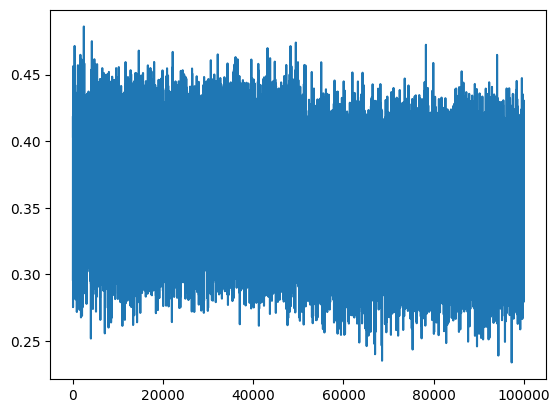

In [15]:
plt.plot(inxs, np.log10(losses))
# plt.xscale("log")

In [16]:
@torch.no_grad() # disable gradient tracking
def get_loss(data_set):
    x, y = {
        'train': (training_set, y_training_set),
        'dev': (dev_set, y_dev_set),
        'test': (test_set, y_test_set)
    }[data_set]

    emb = C[x]
    h_preact = emb.view(emb.shape[0], block_size*n_embd) @ W1 #+ b1
    h_preact = batch_norm_gain * (h_preact - batch_mean_running) / batch_std_running + batch_norm_bias
    h = torch.tanh(h_preact) # (x, hidden)
    logits = h @ W2 + b2 # (hidden, vocab_size )
    loss = F.cross_entropy(logits, y)
    print(data_set, loss.item())

get_loss('train')
get_loss('dev')

train 2.2276742458343506
dev 2.2323195934295654


In [11]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
	out = '.' * block_size
	while True:
		emb = C[torch.tensor([str_to_inx[x] for x in out[-block_size:]])] # (1,block_size,d)
		h = torch.tanh(emb.view(1, -1) @ W1) 
		logits = h @ W2 + b2
		probs = F.softmax(logits, dim=1)
		inx = torch.multinomial(probs, num_samples=1, generator=g).item()
		out = out + inx_to_str[inx]
		if inx == 0:
			break
    
	print(out.replace('.', ''))

chaddixlanghqvigh
mlix
tylyn
ruhsancsrahxthferdry
ttirequx
rumdrixceriar
brlex
bryxthporg
quxdulynlex
dyvindi
ruberrxtthryxi
dudgryslsxttefgygriq
gtysleyah
duldashivlynksya
dubghxxzuky
lle
rusliggrnyel
stdfreggrosssusliyah
badgrosklynnrxe
sxorgelyn
